In [ ]:
from fastparquet import ParquetFile
import pandas as pd
from ml_exp import encode_education
from ml_exp import pull_alzheimer_only
import numpy as np

# CRP
#crp_df = pd.read_csv('../../../uk_biobank/project_52887_669338/ukb669338.csv', usecols=['eid', '30710-0.0'])

# multiple deprivation
#mdi_df = pd.read_csv('../../../uk_biobank/project_52887_41230/ukb41230.csv', usecols = ['26410-0.0', '26427-0.0', '26426-0.0'])

# age sex
demographics_df = pd.read_parquet('demographics.parquet', columns=['eid', '31-0.0', 'curr_age', '6138-0.0'])
encode_education(demographics_df)
demographics_df = demographics_df.drop(columns = ['6138-0.0'])
demographics_df = demographics_df.rename(columns={'IID': 'eid'})

# apoe
apoe_df = pd.read_parquet('raw_apoe_AD.parquet', engine = 'fastparquet')
apoe_df = apoe_df.rename(columns={'IID': 'eid'})

# Merge covariates_df with demographics_df, depression_df, and apoe_df on 'eid'
covariates_df = crp_df.merge(mdi_df, on='eid', how='inner') \
                      .merge(demographics_df, on='eid', how='inner') \
                      .merge(apoe_df, on='eid', how='inner')

# alz diagnosis
ddf = pd.read_parquet('allcausedementia.parquet', engine = 'fastparquet') # age, sex, all-patients
pull_alzheimer_only(covariates_df, ddf)

# depression diagnosis
lancets_dep = pd.read_parquet('../../../randy/rfb/tidy_data/UKBiobank/dementia/lancet2024/lancet2024_preprocessed.parquet', engine = 'fastparquet', columns = ['eid', 'depression'])
covariates_df = covariates_df.merge(lancets_dep, right_on = 'eid', left_on = 'IID', how = 'inner')
covariates_df.drop(columns = ['eid'])

In [ ]:
def summarize_results(results): 
    rows = []

    for test_id, df in results.items():
        # Pull the row for `d` as a dictionary and tag with the test_id
        row = df.loc['d'].to_dict()
        row['test_id'] = test_id
        rows.append(row)

    # Convert to a DataFrame
    summary_df = pd.DataFrame(rows)

    # Move 'test_id' to the front
    summary_df = summary_df[['test_id'] + [col for col in summary_df.columns if col != 'test_id']]

    return summary_df

In [ ]:
def map_race(x):
    if str(x).startswith('1'):
        return 'White'
    elif str(x).startswith('2'):
        return 'Mixed'
    elif str(x).startswith('3'):
        return 'Asian'
    elif str(x).startswith('4'):
        return 'Black'
    elif str(x).startswith('5'):
        return 'Chinese'
    else:
        return None

race_df['race'] = race_df['21000-0.0'].apply(map_race)
race_df = race_df.rename(columns={'eid': 'IID'})

Covariates

In [ ]:
import pandas as pd
covariates_df = pd.read_parquet('doubleML_covariates.parquet', engine = 'fastparquet')

# fill na with means
covariates_df['30710-0.0'] = covariates_df['30710-0.0'].fillna(covariates_df['30710-0.0'].mean())
covariates_df['mdi'] = covariates_df['mdi'].fillna(covariates_df['mdi'].mean())

In [ ]:
covariates_df

In [ ]:
from sklearn.preprocessing import StandardScaler

def scale_continuous_vars(df, continuous_cols):
    """
    Scales the continuous variables in the dataframe using StandardScaler. Returns scaled df. 
    """

    scaler = StandardScaler()

    # Fit and transform only the continuous columns
    scaler.fit(df[continuous_cols])
    df.loc[:, continuous_cols] = scaler.transform(df[continuous_cols])
   
    return df

## Lancet Factors to AD
DoubleML assessing relationship between the lancet factors and their causality on AD. 

In [2]:
import pandas as pd
lancet_vars = [
        "4700-0.0",
        "5901-0.0",
        "30780-0.0",
        "head_injury",
        "22038-0.0",
        "20161-0.0",
        "alcohol_consumption",
        "hypertension",
        "obesity",
        "diabetes",
        "hearing_loss",
        "depression",
        "freq_friends_family_visit",
        "24012-0.0",
        "24018-0.0",
        "24019-0.0",
        "24006-0.0",
        "24015-0.0",
        "24011-0.0"
    ]
continuous_lancet_vars = [
        "4700-0.0",
        "5901-0.0",
        "30780-0.0",
        "22038-0.0",
        "20161-0.0",
        "24012-0.0",
        "24018-0.0",
        "24019-0.0",
        "24006-0.0",
        "24015-0.0",
        "24011-0.0",
    ]

lancets_df = pd.read_parquet('../../../../randy/rfb/tidy_data/UKBiobank/dementia/lancet2024/lancet2024_preprocessed.parquet', engine = 'fastparquet', columns = ['eid'] + lancet_vars)

In [ ]:
lancets_df

In [4]:
import numpy as np
import pandas as pd
from doubleml_utils import encode, scale_continuous_vars

# load in the general covariates
covariates_df = pd.read_parquet('doubleML_covariates.parquet', engine = 'fastparquet', columns=['IID', '31-0.0', 'curr_age', 'bmi', 'mdi', 'e3/e3', 'e2/e3', 'e3/e4', 'e2/e4', 'e4/e4', 'e2/e2', 'education_years'])

# assemble lancet factors
lancets_df.rename(columns={'eid':'IID'}, inplace=True)
lancet_exposures = scale_continuous_vars(lancets_df, continuous_lancet_vars)

/n/groups/patel/helen/adgenes/code/ukb/doubleml_utils.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.12539059 -0.12539059 -0.12539059 ... -0.12539059 -0.12539059
 -0.12539059]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, continuous_cols] = scaler.transform(df[continuous_cols])
/n/groups/patel/helen/adgenes/code/ukb/doubleml_utils.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.06052922 -0.06052922 -0.06052922 ... -0.06052922 -0.06052922
 -0.06052922]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, continuous_cols] = scaler.transform(df[continuous_cols])


In [ ]:
from doubleml_utils import summarize_results

summary_df = summarize_results(results)
summary_df = summary_df.iloc[12:, :]

rename = {
        "4700-0.0": 'Age Cataract Diagnosed',
        "5901-0.0": 'Age Diabetic Retinopathy Diagnosed',
        "30780-0.0": 'LDL',
        "head_injury": 'Head Injury',
        "22038-0.0": 'Min/Week Moderate Activity',
        "20161-0.0": 'Years of Smoking',
        "alcohol_consumption": 'Alcohol consumption',
        "hypertension": 'Hypertension',
        "obesity": 'Obesity',
        "diabetes": 'Diabetes',
        "hearing_loss": 'Hearing Loss',
        "depression_y": 'Depression',
        "freq_friends_family_visit": 'Frequency of Friends/Family Visits',
        "24012-0.0": 'Distance to Major Road',
        "24018-0.0": 'NO2 Air Pollution',
        "24019-0.0": 'PM10 Air Pollution',
        "24006-0.0": 'PM2.5 Air Pollution',
        "24015-0.0": 'Amount of Major Roads',
        "24011-0.0": 'Traffic Intensity',
        '6138-0.0': 'Education Level',
        '845-0.0': 'Age Completed Education',
        'curr_age': 'Current Age',
        '21000-0.0': 'Ethnic Background'

}
summary_df['test_id'] = summary_df['test_id'].replace(rename)
summary_df.sort_values(by='P>|t|', inplace=True)
summary_df


In [ ]:
covariates_df = pd.read_parquet('doubleML_covariates.parquet', engine = 'fastparquet', columns=['IID', '31-0.0', 'curr_age', 'bmi', 'mdi', 'e3/e3', 'e2/e3', 'e3/e4', 'e2/e4', 'e4/e4', 'e2/e2', 'groups'])
covariates_df

In [5]:
from doubleml_utils import run_dml
import pandas as pd

def assess_lancets_dml(lancets): 
    feature_summaries = {}
    confounders = ['31-0.0', 'curr_age', 'bmi', 'mdi', 'e3/e3', 'e2/e3', 'e3/e4', 'e2/e4', 'e4/e4', 'e2/e2']
    
    # Pre-process the data once
    lancets.dropna(subset=confounders + ['groups'], inplace=True)
    base_data = lancets.copy()

    for feature in (lancet_vars + ['education_years']):
        print(f"Running DML for feature: {feature}")

        # Create boolean mask for non-missing values
        valid_mask = ~base_data[feature].isna()
        
        # Check sample size before proceeding
        n_valid = valid_mask.sum()
        if n_valid < 100:
            print(f"Skipping {feature} due to insufficient data ({n_valid} samples)")
            continue

        # Boolean indexing
        covariate = base_data.loc[valid_mask, confounders]
        outcome = base_data.loc[valid_mask, 'groups']
        exposure = base_data.loc[valid_mask, feature]

        try:
            dml_model = run_dml(covariate, outcome, exposure)
            feature_summaries[feature] = dml_model.summary
            print(f"Completed {feature}: {n_valid} samples")
        except Exception as e:
            print(f"Error processing {feature}: {str(e)}")
            continue
    
    return feature_summaries

covariates_df = pd.read_parquet('doubleML_covariates.parquet', engine = 'fastparquet', columns=['IID', '31-0.0', 'curr_age', 'bmi', 'mdi', 'e3/e3', 'e2/e3', 'e3/e4', 'e2/e4', 'e4/e4', 'e2/e2', 'groups', 'education_years'])

covariates_df.rename(columns={'eid':'IID'}, inplace=True)
lancet_exposures = covariates_df.merge(lancet_exposures, on='IID', how='inner')
results = assess_lancets_dml(lancet_exposures)

Running DML for feature: 4700-0.0


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score -0.003457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score -0.002592
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed 4700-0.0: 480065 samples
Running DML for feature: 5901-0.0


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008926
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score -0.002804
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score -0.003624
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed 5901-0.0: 480065 samples
Running DML for feature: 30780-0.0


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 365364, number of used features: 10
[LightGBM] [Info] Start training from score 0.008994
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 365365, number of used features: 10
[LightGBM] [Info] Start training from score 0.008884
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 365364, number of used features: 10
[LightGBM] [Info] Start training from score 0.002952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 365365, number of used features: 10
[LightGBM] [Info] Start training from score 0.002380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed 30780-0.0: 456706 samples
Running DML for feature: head_injury


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.037094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.037456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed head_injury: 480065 samples
Running DML for feature: 22038-0.0


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 310346, number of used features: 10
[LightGBM] [Info] Start training from score 0.008281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 310346, number of used features: 10
[LightGBM] [Info] Start training from score 0.008226
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 310346, number of used features: 10
[LightGBM] [Info] Start training from score 0.000627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 310346, number of used features: 10
[LightGBM] [Info] Start training from score 0.002637
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed 22038-0.0: 387933 samples
Running DML for feature: 20161-0.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 115720, number of used features: 10
[LightGBM] [Info] Start training from score 0.010067


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 115721, number of used features: 10
[LightGBM] [Info] Start training from score 0.009860
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 115721, number of used features: 10
[LightGBM] [Info] Start training from score 0.009609
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 115720, number of used features: 10
[LightGBM] [Info] Start training from score -0.008451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 115721, number of used features: 10
[LightGBM] [Info] Start training from score -0.008803
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed 20161-0.0: 144651 samples
Running DML for feature: alcohol_consumption


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.009014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 4.052006
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 4.051191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed alcohol_consumption: 480065 samples
Running DML for feature: hypertension


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.009064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008994
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.336546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.336733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed hypertension: 480065 samples
Running DML for feature: obesity


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008931
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.009108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.104304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.104298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed obesity: 480065 samples
Running DML for feature: diabetes


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008824
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008871
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.094646
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.094297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed diabetes: 480065 samples
Running DML for feature: hearing_loss


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.055209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.055282
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed hearing_loss: 480065 samples
Running DML for feature: depression


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.090141
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.090178
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed depression: 480065 samples
Running DML for feature: freq_friends_family_visit


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.009022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 0.008887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 6.169206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 384052, number of used features: 10
[LightGBM] [Info] Start training from score 6.167371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed freq_friends_family_visit: 480065 samples
Running DML for feature: 24012-0.0


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score 0.008960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score 0.008931
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score -0.000055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score -0.001611
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed 24012-0.0: 473082 samples
Running DML for feature: 24018-0.0


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score 0.008968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score 0.008960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score -0.012157
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score -0.011645
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed 24018-0.0: 473082 samples
Running DML for feature: 24019-0.0


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 377618, number of used features: 10
[LightGBM] [Info] Start training from score 0.008953
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 377618, number of used features: 10
[LightGBM] [Info] Start training from score 0.009020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 377618, number of used features: 10
[LightGBM] [Info] Start training from score -0.005751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 377618, number of used features: 10
[LightGBM] [Info] Start training from score -0.005832
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed 24019-0.0: 472023 samples
Running DML for feature: 24006-0.0


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 352373, number of used features: 10
[LightGBM] [Info] Start training from score 0.008812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 352373, number of used features: 10
[LightGBM] [Info] Start training from score 0.008795
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 352373, number of used features: 10
[LightGBM] [Info] Start training from score -0.004290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 352373, number of used features: 10
[LightGBM] [Info] Start training from score -0.006456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed 24006-0.0: 440467 samples
Running DML for feature: 24015-0.0


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score 0.008928
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score 0.009026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score -0.000338
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score -0.001535
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed 24015-0.0: 473082 samples
Running DML for feature: 24011-0.0


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score 0.008923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score 0.008838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score -0.006537
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 378465, number of used features: 10
[LightGBM] [Info] Start training from score -0.007386
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed 24011-0.0: 473082 samples
Running DML for feature: education_years


/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 252617, number of used features: 10
[LightGBM] [Info] Start training from score 0.010613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 252617, number of used features: 10
[LightGBM] [Info] Start training from score 0.010550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 252617, number of used features: 10
[LightGBM] [Info] Start training from score 16.705119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 252617, number of used features: 10
[LightGBM] [Info] Start training from score 16.703444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/heq754/.conda/envs/lowpyAD/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

Completed education_years: 315772 samples


In [7]:
from doubleml_utils import summarize_results
summary_df = summarize_results(results) 
#summary_df.sort_values(by='P>|t|')[summary_df['P>|t|'] < 0.05]
summary_df.sort_values(by='P>|t|')

,test_id,coef,std err,t,P>|t|,2.5 %,97.5 %
3,head_injury,0.031101,0.001480,21.018817,4.412968e-98,0.028201,0.034001
11,depression,0.013492,0.000690,19.550954,4.048756e-85,0.012140,0.014845
7,hypertension,0.004594,0.000344,13.359032,1.049200e-40,0.003920,0.005268
9,diabetes,0.008818,0.000680,12.973268,1.734724e-38,0.007486,0.010150
6,alcohol_consumption,-0.000883,0.000098,-8.990705,2.456506e-19,-0.001076,-0.000691
10,hearing_loss,0.006629,0.000861,7.700342,1.357028e-14,0.004942,0.008316
2,30780-0.0,-0.001040,0.000163,-6.392144,1.635758e-10,-0.001359,-0.000721
19,education_years,-0.000323,0.000074,-4.380967,1.181537e-05,-0.000467,-0.000178
16,24006-0.0,0.000618,0.000149,4.158739,3.200099e-05,0.000327,0.000910
1,5901-0.0,0.000720,0.000221,3.262165,1.105649e-03,0.000287,0.001152


In [8]:
summary_df.to_csv('./double_ml/ukbiobank_lancet.txt')

In [ ]:
import numpy as np

# depression snps
loaded = np.load('depression.npz', allow_pickle=True)
data = loaded['data']
columns = loaded['columns']
depression_df = pd.DataFrame(data, columns=columns)

# some cleaning
#depression_df = pd.read_parquet('raw_allsnps_depression.parquet', engine = 'fastparquet')
depression_df = depression_df.drop(columns = ['FID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE'])


In [ ]:
covariates_df = covariates_df.ffill().bfill()

Proteomics and AD

In [ ]:
import pandas as pd
covariates_df = pd.read_parquet('doubleML_dep_AD_covariates.parquet', engine = 'fastparquet')

# fill na with means
covariates_df['30710-0.0'] = covariates_df['30710-0.0'].fillna(covariates_df['30710-0.0'].mean())
covariates_df['mdi'] = covariates_df['mdi'].fillna(covariates_df['mdi'].mean())
covariates_df['6138-0.0'] = covariates_df['6138-0.0'].fillna(-3.0)

covariates_df = encode_education(covariates_df, col='6138-0.0', prefix='education').drop(columns=['6138-0.0', 'education_-3.0'])

In [ ]:
df = pd.read_parquet('../../../randy/rfb/tidy_data/UKBiobank/dementia/proteomics/X.parquet', engine = 'fastparquet')
    # Get all protein columns (ending with -0) plus the eid column

protein_cols = [col for col in df.columns if col.endswith('-0')]
covariates = df.loc[:, ~df.columns.isin(protein_cols)]

In [ ]:
covariates.columns

In [ ]:
def assess_proteomics_prottoAD(covariates_df):
    fold = 0
    df = pd.read_parquet('../../../randy/rfb/tidy_data/UKBiobank/dementia/proteomics/X.parquet', engine = 'fastparquet')
    # Get all protein columns (ending with -0) plus the eid column

    protein_cols = [col for col in df.columns if col.endswith('-0')]
    curr_protein_cols = protein_cols[fold*10:(fold+1)*10]  # Select 100 proteins for this fold
    
    # Keep eid and the current proteins
    curr_proteins = df[['eid'] + curr_protein_cols].rename(columns={'eid': 'IID'})

    # Subset covariates_df to only include rows with 'IID' present in curr_proteins
    covariates_df = covariates_df.merge(curr_proteins, on='IID', how='inner')

    results = {}

    for prot in curr_proteins.drop(columns = ['IID']).columns:
        
        print(f"Running DML for protein: {prot}")
        covariate = covariates_df[['31-0.0', 'curr_age']]
        outcome = covariates_df['groups']
        exposure = covariates_df[prot]

        if exposure.isna().sum() > 0: 
            subset_IIDs = exposure[exposure.isna()].index
            covariate = covariate.loc[~covariate.index.isin(subset_IIDs)]
            outcome = outcome.loc[~outcome.index.isin(subset_IIDs)] 
            exposure = exposure.loc[~exposure.index.isin(subset_IIDs)]
    
        dml_model = run_dml(covariate, outcome, exposure)
        results[prot] = dml_model.summary
    
    return results

results = assess_proteomics_prottoAD(covariates_df)

In [ ]:
import pandas as pd
df = pd.read_parquet('demographics.parquet', engine = 'fastparquet')
df.shape


In [ ]:
protein_df = pd.read_parquet('../../../randy/rfb/tidy_data/UKBiobank/dementia/proteomics/X.parquet', engine='fastparquet').rename(columns = {'eid':'IID'})


In [ ]:
protein_df

In [ ]:
dml_df = pd.read_parquet('doubleML_covariates.parquet', engine = 'fastparquet')

In [ ]:
dml_df['race'].value_counts()

In [ ]:
dml_df['']

In [ ]:
df['21003-0.0'][df['21003-0.0'] > 65].value_counts().sum()

In [ ]:
covariates_df = pd.read_parquet('doubleML_dep_AD_covariates.parquet', engine = 'fastparquet')

# fill na with means
covariates_df['30710-0.0'] = covariates_df['30710-0.0'].fillna(covariates_df['30710-0.0'].mean())
covariates_df['mdi'] = covariates_df['mdi'].fillna(covariates_df['mdi'].mean())
covariates_df['6138-0.0'] = covariates_df['6138-0.0'].fillna(-3.0)

def assess_proteomics_lancettoprot(covariates_df, lancet_factor):
    fold = 0
    df = pd.read_parquet('../../../randy/rfb/tidy_data/UKBiobank/dementia/proteomics/X.parquet', engine='fastparquet')
    
    protein_cols = [col for col in df.columns if col.endswith('-0')]
    total_proteins = len(protein_cols)

    start_idx = fold * 100
    end_idx = min((fold + 1) * 100, total_proteins)
    
    # Skip if this fold has no proteins to process
    if start_idx >= total_proteins:
        print(f"Fold {fold}: No proteins to process (start_idx {start_idx} >= total_proteins {total_proteins})")
        return {}
    
    curr_protein_cols = protein_cols[start_idx:end_idx]
    print(f"Fold {fold}: Processing {len(curr_protein_cols)} proteins (indices {start_idx}-{end_idx-1})")
    
    # rename and merge
    curr_proteins = df[['eid'] + curr_protein_cols].rename(columns={'eid': 'IID'})
    #exposure_df = df[['eid', lancet_factor]].rename(columns={'eid': 'IID'})
    
    covariates_df = covariates_df.merge(curr_proteins, on='IID', how='inner')
    #covariates_df = covariates_df.merge(exposure_df, on='IID', how='inner')
    
    results = {}

    for prot in curr_proteins.drop(columns=['IID']).columns:
        print(f"Running DML for protein: {prot}")
        covariate = covariates_df[['31-0.0', 'curr_age']] #.ffill().bfill()
        outcome = covariates_df[prot] #.ffill().bfill()
        exposure = covariates_df[lancet_factor] #.ffill().bfill()

        if lancet_factor in continuous_lancet_vars:
            exposure = exposure #.fillna(exposure.mean())
            # Note: scale_continuous_vars expects a DataFrame, not a Series
            exposure_scaled = scale_continuous_vars(pd.DataFrame({lancet_factor: exposure}), [lancet_factor])
            exposure = exposure_scaled[lancet_factor]
        else:
            exposure = exposure #.ffill().bfill()
        
        if outcome.isna().sum() > 0:
            subset_IIDs = outcome[outcome.isna()].index
            covariate = covariate.loc[~covariate.index.isin(subset_IIDs)]
            outcome = outcome.loc[~outcome.index.isin(subset_IIDs)] 
            exposure = exposure.loc[~exposure.index.isin(subset_IIDs)]

        if exposure.isna().sum() > 0:
            subset_IIDs = exposure[exposure.isna()].index
            covariate = covariate.loc[~covariate.index.isin(subset_IIDs)]
            outcome = outcome.loc[~outcome.index.isin(subset_IIDs)] 
            exposure = exposure.loc[~exposure.index.isin(subset_IIDs)]

        dml_model = run_dml(covariate, outcome, exposure)
        results[prot] = dml_model.summary
    
    return results
    
results = assess_proteomics_lancettoprot(covariates_df, 'education_years')
    

In [ ]:
covariates_df

In [ ]:
results = assess_proteomics_lancettoprot(covariates_df, 'depression')

In [ ]:
import pandas as pd

rows = []
for protein, df in results.items():
    df = df.copy()
    df['protein'] = protein
    rows.append(df.reset_index())

summary_df = pd.concat(rows, ignore_index=True)
#summary_df.to_csv(f'./double_ml/results_proteomics_edtoprot/proteomics_educ_fold{fold}.csv', index=False)

In [90]:
# merge all folds
import os
import pandas as pd
from ukb_utils import get_protein_lookup
from statsmodels.stats.multitest import multipletests

def merge_folds(exp):
    path = f'./double_ml/proteomics/results/{exp}/'
    all_results = []

    for fname in os.listdir(path):
        if fname.startswith('fold'):
            df = pd.read_csv(os.path.join(path, fname), sep=None, engine='python')
            all_results.append(df)

    massive_df = pd.concat(all_results, ignore_index=True)
    massive_df = massive_df.drop_duplicates(subset=['index', 'protein'])

    massive_df.to_csv(f'./double_ml/proteomics/results/{exp}/all_results.csv', index=False)

    return massive_df



In [ ]:
df = merge_folds('education_years_to_prot')

In [ ]:
df

In [91]:
import os
overlapping = {}
for folder in os.listdir('./double_ml/proteomics/results'):
    if folder.endswith('_to_prot'):
        #df = merge_folds(folder)

        df = pd.read_csv(os.path.join('./double_ml/proteomics/results', folder, 'all_results.csv'))

        ad_df = pd.read_csv('./double_ml/proteomics/results/prot_to_AD/all_results.csv')

        rejected, sig_lancet_p, _, _ = multipletests(df['P>|t|'], alpha=0.05, method='fdr_bh')
        sig_lancet_prots = df[df['P>|t|'].isin(sig_lancet_p)]['protein'].sort_values()

        rejected, sig_AD_p, _, _ = multipletests(ad_df[ad_df['P>|t|'] < 0.05]['P>|t|'], alpha=0.05, method='fdr_bh')
        sig_AD_prots = ad_df[ad_df['P>|t|'].isin(sig_AD_p)]['protein'].sort_values()

        # sig_AD_prots = ad_df[ad_df['P>|t|'] < 0.05][['protein', 'P>|t|', 'coef']]
        # sig_lancet_prots = df[df['P>|t|'] < 0.05][['protein', 'P>|t|', 'coef']]

        # Find overlap between sig_AD_prots and shared_proteins
        overlap = set(sig_AD_prots['protein']) & set(sig_lancet_prots['protein'])
        print(f"Overlap between sig_AD_prots and {folder}:", overlap)

        overlap_df = sig_AD_prots[sig_AD_prots['protein'].isin(overlap)]
        overlap_df['protein'] = overlap_df['protein'].astype(str).str.split('-').str[0]
        overlap_df['protein'] = overlap_df['protein'].astype(int)

        # protein lookup
        protein_lookup = get_protein_lookup()
        results = protein_lookup[protein_lookup['coding'].isin(overlap_df['protein'])]

        results = results.merge(overlap_df, left_on='coding', right_on='protein', how='inner')

        results.to_csv(f'./double_ml/results/{folder}/overlapping_proteins_fdr.csv', index=False)


KeyError: 'protein'

In [ ]:
# FDR correction for prot_to_AD
df = merge_folds('prot_to_AD_apoe_regressed')

# Apply FDR correction to ALL p-values first
rejected, sig_AD_p, _, _ = multipletests(df['P>|t|'], alpha=0.05, method='fdr_bh')

# Get significant proteins based on FDR-corrected p-values
sig_AD_prots = df[rejected].copy()  # Use the 'rejected' boolean array

# Sort by original p-values
sig_AD_prots = sig_AD_prots[['protein', 'P>|t|', 'coef']].sort_values(by='P>|t|')

print(f"Number of significant proteins after FDR correction: {len(sig_AD_prots)}")

# Only proceed if there are significant proteins
if len(sig_AD_prots) > 0:
    # Extract the numeric part before '-0' and convert to int
    sig_AD_prots['protein_code'] = sig_AD_prots['protein'].str.split('-').str[0].astype(int)
    
    protein_lookup = get_protein_lookup()
    results = protein_lookup[protein_lookup['coding'].isin(sig_AD_prots['protein_code'])]

    sig_AD_prots = sig_AD_prots.merge(results, left_on='protein_code', right_on='coding', how='inner')

    print(f"Final shape: {sig_AD_prots.shape}")
    print(sig_AD_prots[['protein', 'P>|t|', 'coef', 'part_2', 'part_1']].head(10))
else:
    print("No proteins survived FDR correction at alpha=0.05")
    sig_AD_prots = pd.DataFrame()  # Empty dataframe

sig_AD_prots.shape

In [ ]:
import pandas as pd
sig_AD_prots[['protein', 'P>|t|', 'coef', 'part_2']].to_csv('./double_ml/proteomics/results/prot_to_AD/proteins_fdr.csv')

In [84]:
from collections import Counter

protein_lists = list(overlapping.values())
all_proteins = [protein for sublist in protein_lists for protein in sublist]
protein_counts = Counter(all_proteins)

N = 17  # Change this to the minimum number of lists you want a protein to appear in

shared_proteins = [protein for protein, count in protein_counts.items() if count >= N]

print(f"Proteins present in at least {N} lists:", shared_proteins)


TypeError: 'numpy.ndarray' object is not callable

In [11]:
import os
import pandas as pd
from collections import Counter

# Path to results directory
results_dir = './double_ml/proteomics/results'

# Collect all overlapping protein lists from folders ending with _to_prot
overlapping = {}
for folder in os.listdir(results_dir):
    if folder.endswith('_to_prot'):
        overlap_path = os.path.join(results_dir, folder, 'overlapping_proteins_fdr.csv')
        if os.path.exists(overlap_path):
            df = pd.read_csv(overlap_path)
            proteins = df['coding'].astype(int).tolist()

print(overlapping)
            

# Flatten all protein lists and count occurrences
all_proteins = [protein for sublist in overlapping.values() for protein in sublist]
protein_counts = Counter(all_proteins)

# Find proteins present in at least 14 folders
shared_proteins = [protein for protein, count in protein_counts.items() if count >= 1]

print(f"Proteins present in at least 14 lancet factor overlaps: {shared_proteins}")
len(shared_proteins)

{}
Proteins present in at least 14 lancet factor overlaps: []


0

In [19]:
table = pd.DataFrame()
for folder in os.listdir(results_dir):
    if folder.endswith('_to_prot'):
        overlap_path = os.path.join(results_dir, folder, 'overlapping_proteins_fdr.csv')
        print(overlap_path)
        factor = folder.split('_to_')[0]
        if os.path.exists(overlap_path):
            df = pd.read_csv(overlap_path)
            if df['coding'].isin(shared_proteins).sum() != len(shared_proteins):
                print(f"No shared proteins found in {factor}, skipping.")
                continue
            else: 
                coef_col = df[df['coding'].isin(shared_proteins)][f'coef_{factor}_to_prot']
                table[factor] = coef_col.values
            

./double_ml/proteomics/results/20161-0.0_to_prot/overlapping_proteins_fdr.csv
No shared proteins found in 20161-0.0, skipping.
./double_ml/proteomics/results/22038-0.0_to_prot/overlapping_proteins_fdr.csv
No shared proteins found in 22038-0.0, skipping.
./double_ml/proteomics/results/24006-0.0_to_prot/overlapping_proteins_fdr.csv
No shared proteins found in 24006-0.0, skipping.
./double_ml/proteomics/results/24011-0.0_to_prot/overlapping_proteins_fdr.csv
No shared proteins found in 24011-0.0, skipping.
./double_ml/proteomics/results/24012-0.0_to_prot/overlapping_proteins_fdr.csv
No shared proteins found in 24012-0.0, skipping.
./double_ml/proteomics/results/24015-0.0_to_prot/overlapping_proteins_fdr.csv
No shared proteins found in 24015-0.0, skipping.
./double_ml/proteomics/results/24018-0.0_to_prot/overlapping_proteins_fdr.csv
No shared proteins found in 24018-0.0, skipping.
./double_ml/proteomics/results/24019-0.0_to_prot/overlapping_proteins_fdr.csv
No shared proteins found in 24019

In [13]:
protein_lookup[protein_lookup['coding'].isin(shared_proteins)]

,coding,part_1,part_2
241,242,BCAN,Brevican core protein
284,285,BRK1,Protein BRICK1
533,534,CES1,Liver carboxylesterase 1
558,559,CHI3L1,Chitinase-3-like protein 1
1023,1024,FCRL5,Fc receptor-like protein 5
1092,1093,FURIN,Furin
1136,1137,GDF15,Growth/differentiation factor 15
1287,1288,HPGDS,Hematopoietic prostaglandin D synthase
1343,1344,IGFBP2,Insulin-like growth factor-binding protein 2
1344,1345,IGFBP3,Insulin-like growth factor-binding protein 3


Proteomics Plot

In [7]:
def get_protein_lookup():
    """ Load the protein lookup table from the coding143.tsv file.
    This file contains the mapping of protein IDs to their meanings, which may include multiple parts separated by semicolons.
    Returns:
        pd.DataFrame: A DataFrame containing the protein codes and their meanings, with the meanings split into separate columns.
    """
    # Load the coding143.tsv file from the metadata directory
    # Assuming the file is located two directories up from the current file's directory
    # Adjust the path as necessary based on your project structure
    # Use Path to ensure compatibility across different operating systems
    # Note: This assumes the file is located at ../../metadata/coding143.tsv relative to this script's location

    # Get the directory of the current file
    # and construct the path to the coding143.tsv file    
    
    protein_code = pd.read_csv('../../../../randy/rfb/metadata/coding143.tsv', sep='\t')

    # Split the column by semicolon and expand into separate columns
    split_columns = protein_code['meaning'].str.split(';', expand=True)

    # Rename the new columns (optional)
    split_columns.columns = [f'part_{i+1}' for i in range(split_columns.shape[1])]

    # Concatenate the new columns with the original DataFrame (optional)
    protein_code = pd.concat([protein_code, split_columns], axis=1)

    # Drop the original column if no longer needed
    protein_code = protein_code.drop('meaning', axis=1)
    
    return protein_code    

protein_lookup = get_protein_lookup()

In [ ]:
df = pd.read_csv('./double_ml/proteomics/results/depression_to_prot/all_results.csv')
df['protein'] = df['protein'].str.split('-').str[0].astype(int)
df = df.merge(protein_lookup, left_on='protein', right_on='coding', how='left')

,index,coef,std err,t,P>|t|,2.5 %,97.5 %,protein,coding,part_1,part_2
0,d,0.080846,0.005307,15.232776,2.142951e-52,0.070443,0.091248,2738,2738,TNFSF13B,Tumor necrosis factor ligand superfamily membe...
1,d,0.041043,0.004887,8.398188,4.534225e-17,0.031464,0.050622,2737,2737,TNFSF13,Tumor necrosis factor ligand superfamily membe...
2,d,-0.019498,0.005139,-3.794149,1.481505e-04,-0.029570,-0.009426,2736,2736,TNFSF12,Tumor necrosis factor ligand superfamily membe...
3,d,-0.060193,0.010883,-5.530940,3.185188e-08,-0.081523,-0.038862,2735,2735,TNFSF11,Tumor necrosis factor ligand superfamily membe...
4,d,0.007349,0.004568,1.608830,1.076535e-01,-0.001604,0.016301,2734,2734,TNFSF10,Tumor necrosis factor ligand superfamily membe...
...,...,...,...,...,...,...,...,...,...,...,...
2918,d,0.064444,0.007702,8.366727,5.924082e-17,0.049347,0.079540,2877,2877,VWA1,von Willebrand factor A domain-containing prot...
2919,d,0.062277,0.016180,3.848879,1.186596e-04,0.030564,0.093990,2884,2884,WASF1,Wiskott-Aldrich syndrome protein family member 1
2920,d,0.020474,0.011558,1.771393,7.649537e-02,-0.002180,0.043128,2883,2883,WAS,Wiskott-Aldrich syndrome protein
2921,d,0.023747,0.006601,3.597803,3.209165e-04,0.010811,0.036684,2882,2882,WARS,"Tryptophan--tRNA ligase, cytoplasmic"


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.stats.multitest as smm

#reject, p_vals_corrected, _, _ = smm.multipletests(massive_df['P>|t|'], method='fdr_bh', alpha = 0.05)
df = pd.read_csv('./double_ml/proteomics/results/depression_to_prot/all_results.csv')
df['protein'] = df['protein'].str.split('-').str[0].astype(int)
df = df.merge(protein_lookup, left_on='protein', right_on='coding', how='left')

reject, p_vals_corrected, _, _ = smm.multipletests(df['P>|t|'], method='fdr_bh', alpha = 0.05)

# Calculate mean and std of the coefficients
mean_coef = df['coef'].mean()
std_coef = df['coef'].std()


plt.figure(figsize=(8, 6))
#plt.scatter(df['coef'], -np.log10(p_vals_corrected), alpha=0.5)

top_prots = df.sort_values(by='coef', key=abs, ascending=False).head(10)

for _, row in top_prots.iterrows():
    plt.annotate(
        row['part_1'],
        (row['coef'], -np.log10(row['P>|t|'])), 
        fontsize=9,
        ha='center',
        va='bottom'
    )

# Mark overlap proteins
df['is_overlap'] = df['protein'].isin(overlap['coding'])

# Example with matplotlib scatter
plt.scatter(
    df['coef'], 
    -np.log10(df['P>|t|']), 
    c=df['is_overlap'].map({True: 'red', False: 'grey'}),
    alpha=0.7
)


plt.xlabel('Betas')
plt.ylabel('-log10(p-value)')
plt.title('Depression Causal Effect on Proteomics (FDR corrected)')
plt.grid(True)
plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='p = 0.05')
plt.legend()
plt.show()

NameError: name 'protein_lookup' is not defined

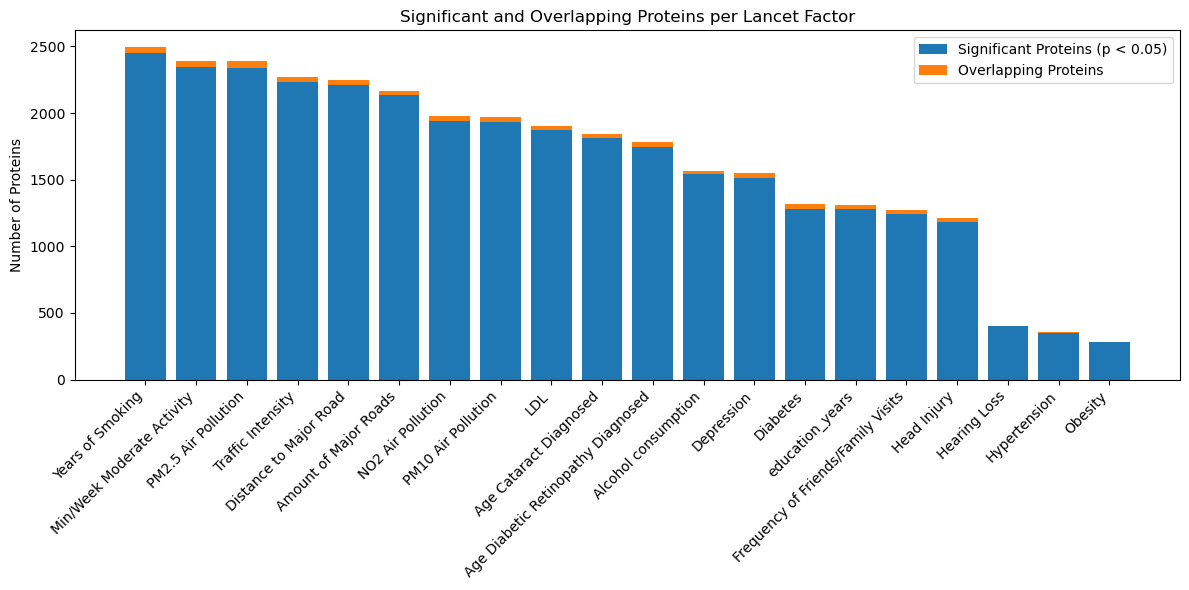

In [2]:
import os
import pandas as pd
import numpy as np
from doubleml_utils import rename_vars
import matplotlib.pyplot as plt

root = './double_ml/proteomics/results'

rename = rename_vars()

# Prepare data for plotting
folders = []
total_proteins = []
overlapping_proteins = []



for folder in os.listdir(root):
    if folder.endswith('_to_prot'):
        folders.append(folder.split('_to_')[0])  # Extract lancet factor name
        all_prots = pd.read_csv(os.path.join(root, folder, 'all_results.csv'))
        all_sig = all_prots[all_prots['P>|t|'] < 0.05]
        total_proteins.append(len(all_sig))

        overlap_prots = pd.read_csv(os.path.join(root, folder, 'overlapping_proteins_fdr.csv'))
        overlapping_proteins.append(len(overlap_prots))

df = pd.DataFrame({
    'Lancet Factor': folders,
    'Significant Proteins': total_proteins,
    'Overlapping Proteins': overlapping_proteins
})

df.sort_values(by='Significant Proteins', ascending=False, inplace=True)

# Create stacked barplot
x = np.arange(len(folders))
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x, df['Significant Proteins'], label='Significant Proteins (p < 0.05)')
ax.bar(x, df['Overlapping Proteins'], bottom=df['Significant Proteins'], label='Overlapping Proteins')

folders = [rename.get(f, f) for f in folders]

ax.set_xticks(x)
ax.set_xticklabels(folders, rotation=45, ha='right')
ax.set_ylabel('Number of Proteins')
ax.set_title('Significant and Overlapping Proteins per Lancet Factor')
ax.legend()
plt.tight_layout()
plt.show()



Analyzing Protein Level with CATE

In [3]:
import pandas as pd
from doubleml_utils import run_dml

# interaction 
covariates_df = pd.read_parquet('doubleML_AD_covariates.parquet', engine = 'fastparquet')

# Multiply education_years to the APOE genotype columns in covariates_df
apoe_cols = ['e2/e2', 'e2/e3', 'e3/e4', 'e2/e4', 'e4/e4'] #'e3/e3' as the reference level
covariates_df[apoe_cols] = covariates_df[apoe_cols].multiply(covariates_df['education_years'], axis=0)

covariates_df = covariates_df.dropna(subset='education_years', how='all')  # Drop rows where all APOE columns are NaN


covariate = covariates_df[['curr_age', '31-0.0'] + apoe_cols + ['education_years']]
outcome = covariates_df['groups']
exposure = covariates_df[apoe_cols]

print(covariate.isna().sum())

exposure = exposure.fillna(0)  # Fill NaN values with 0 for the exposure variables

dml_model = run_dml(covariate, outcome, exposure)

FileNotFoundError: [Errno 2] No such file or directory: 'doubleML_AD_covariates.parquet'

In [ ]:
# ['e2/e2', 'e3/e3', 'e2/e3', 'e3/e4', 'e2/e4', 'e4/e4']
dml_model.summary

In [ ]:
# Grid of treatment values
d_vals = np.linspace(np.percentile(D, 5), np.percentile(D, 99), 50)

# Average effect at each treatment level
mu_d = [cf.effect(X, T0=0, T1=d).mean() for d in d_vals]

# Plot
import matplotlib.pyplot as plt
plt.plot(d_vals, mu_d, lw=2)
plt.xlabel("Treatment level D")
plt.ylabel("Estimated E[Y(d)] - E[Y(0)]")
plt.title("Estimated Dose-Response Curve (Relative to D=0)")
plt.grid(True)
plt.show()

Depression and CATES

In [5]:
import pandas as pd
dml_df = pd.read_parquet('doubleML_covariates.parquet', engine = 'fastparquet')
dml_df.shape

In [ ]:
hypertension = pd.read_parquet('../../../randy/rfb/tidy_data/UKBiobank/dementia/lancet2024/lancet2024_preprocessed.parquet', engine = 'fastparquet', columns=['eid', 'hypertension'])
hypertension.rename(columns={'eid': 'IID'}, inplace=True)


In [ ]:
dml_df = dml_df.merge(hypertension, on='IID', how='inner')

/tmp/ipykernel_863770/2258514322.py:30: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.sparse.csr.csr_matrix.A = property(lambda self: self.toarray())
/tmp/ipykernel_863770/2258514322.py:31: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.sparse.csc.csc_matrix.A = property(lambda self: self.toarray())


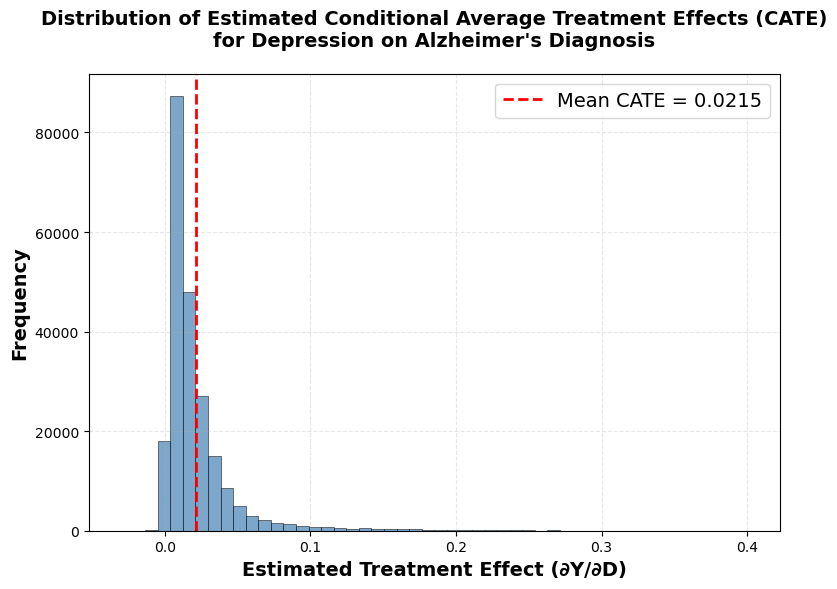

In [8]:
# cates for depression on AD
import numpy as np
import pandas as pd
from econml.dr import DRLearner
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
import matplotlib.pyplot as plt
from doubleml_utils import encode

import numpy as np
import scipy.sparse


# dml_df = pd.read_parquet('doubleML_covariates.parquet', engine = 'fastparquet')
# #protein_df = pd.read_parquet('../../../randy/rfb/tidy_data/UKBiobank/dementia/proteomics/X.parquet', engine='fastparquet', columns=['eid'] + ['1141-0']).rename(columns = {'eid':'IID'})

dml_df = dml_df[dml_df['curr_age'] > 65]


# drop na
dml_df = dml_df.dropna(subset=['education_years', 'curr_age', '31-0.0', 'groups', 'depression'])
dml_df = encode(dml_df, col = 'race', prefix = 'race')

np.int = int  
scipy.sparse.csr.csr_matrix.A = property(lambda self: self.toarray())
scipy.sparse.csc.csc_matrix.A = property(lambda self: self.toarray())

covs = ['curr_age', '31-0.0', 'e3/e3', 'e2/e3', 'e3/e4', 'e2/e4', 'e4/e4', 'e2/e2', 'education_years', 'mdi']

X = dml_df.loc[:, covs]

D = dml_df['depression']
Y = dml_df['groups']

if D.isna().sum() > 0:
    subset_IIDs = D[D.isna()].index
    X = X.loc[~X.index.isin(subset_IIDs)]
    Y = Y.loc[~Y.index.isin(subset_IIDs)]
    D = D.loc[~D.index.isin(subset_IIDs)]


cf = CausalForestDML(model_y=GradientBoostingClassifier(),
                     model_t=GradientBoostingRegressor(),
                     discrete_treatment=False,
                     discrete_outcome=True,
                     cv=5, n_estimators=100,
                     min_samples_leaf=10, max_depth=10,
                     random_state=123)

cf.fit(Y, D, X=X)

# Estimate marginal effects
tau_hat = cf.effect(X, T0=0, T1=1)

# Plot histogram with publication-ready styling
plt.figure(figsize=(8, 6))
plt.hist(tau_hat, bins=50, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
plt.title("Distribution of Estimated Conditional Average Treatment Effects (CATE)\nfor Depression on Alzheimer's Diagnosis",
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Estimated Treatment Effect (∂Y/∂D)", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.axvline(x=np.mean(tau_hat), color='red', linestyle='--', linewidth=2,
           label=f'Mean CATE = {np.mean(tau_hat):.4f}')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# calculating partial dependence
import numpy as np

# Create a grid for age (e.g., 50 to 80 years)
age_grid = np.linspace(X["curr_age"].min(), X["curr_age"].max(), 50)
pdp_values = []

for age in age_grid:
    X_temp = X.copy()
    X_temp["curr_age"] = age
    cate = cf.effect(X_temp)  # CATE as probability difference
    pdp_values.append(np.mean(cate))  # Average over all samples

pdp_values = np.array(pdp_values)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for aesthetics
sns.set(style="whitegrid", palette="viridis")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(age_grid, pdp_values, color="#1b9e77", linewidth=2, label="Partial Dependence")
plt.fill_between(age_grid, pdp_values - 0.01, pdp_values + 0.01, 
                 color="#1b9e77", alpha=0.2)  # Placeholder CI
plt.xlabel("Age", fontsize=12)
plt.ylabel("CATE (Probability Difference)", fontsize=12)
plt.title("Partial Dependence of Depression on Alzheimer’s Diagnosis by Age", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# sensitivity plot

from doubleml_utils import run_dml

dml_obj = run_dml(dml_df.loc[:, covs], dml_df['groups'], dml_df['depression'])

dml_obj.summary

dml_obj.sensitivity_analysis()
print(dml_obj.sensitivity_summary)

dml_obj.sensitivity_plot()

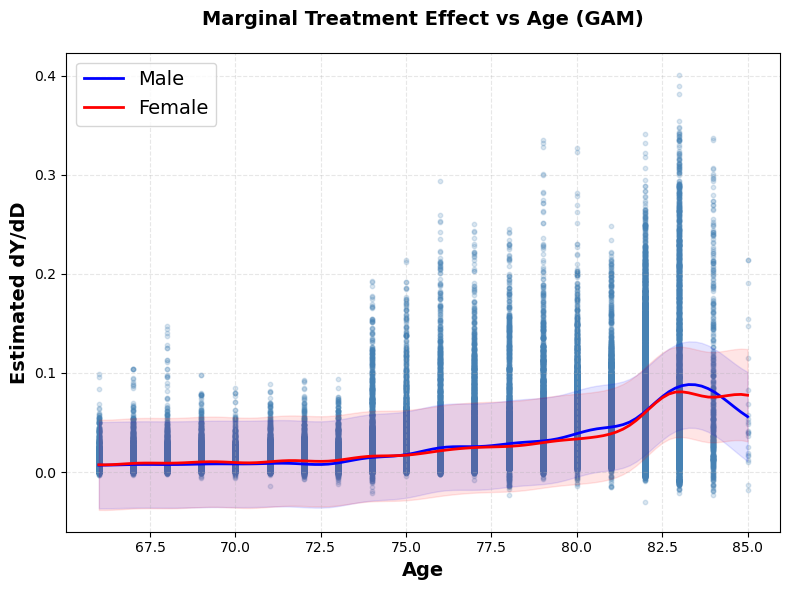

In [9]:
##################################################################
# plotting age against change in risk
import matplotlib.pyplot as plt


# Estimated CATE (marginal effects)
tau_hat = cf.effect(X)
tau_arr = tau_hat

# Plot tau vs X1
# plt.scatter(X.iloc[:, 2], tau_hat, alpha=0.3)

# Fit GAM
dep_arr= X.iloc[:, 0].to_numpy(dtype=float).reshape(-1, 1)

# plot sex curves
sex_arr = X['31-0.0'].to_numpy()
male_idx = sex_arr == 0
female_idx = sex_arr == 1

# Fit GAM for males
gam_male = LinearGAM(s(0)).fit(dep_arr[male_idx], tau_arr[male_idx])
# educ_grid is a grid of age values for prediction, spanning the observed age range
educ_grid = np.linspace(dep_arr.min(), dep_arr.max(), 100).reshape(-1, 1)
pred_male = gam_male.predict(educ_grid)
conf_male = gam_male.prediction_intervals(educ_grid, width=0.95)

# Fit GAM for females
gam_female = LinearGAM(s(0)).fit(dep_arr[female_idx], tau_arr[female_idx])
pred_female = gam_female.predict(educ_grid)
conf_female = gam_female.prediction_intervals(educ_grid, width=0.95)

# # Predict on grid
# educ_grid = np.linspace(educ_arr.min(), educ_arr.max(), 100).reshape(-1, 1)
# pred = gam.predict(educ_grid)
# conf = gam.prediction_intervals(educ_grid, width=0.95)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(dep_arr, tau_arr, alpha=0.2, s=10, color='steelblue')
plt.plot(educ_grid, pred_male, color='blue', lw=2, label='Male')
plt.fill_between(educ_grid.ravel(), conf_male[:, 0], conf_male[:, 1], color='blue', alpha=0.1)

plt.plot(educ_grid, pred_female, color='red', lw=2, label='Female')
plt.fill_between(educ_grid.ravel(), conf_female[:, 0], conf_female[:, 1], color='red', alpha=0.1)

plt.xlabel("Age", fontsize=14, fontweight='bold')
plt.ylabel("Estimated dY/dD", fontsize=14, fontweight='bold')
plt.title("Marginal Treatment Effect vs Age (GAM)", fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

Covariates and Cognitive Testing

In [ ]:
import pandas as pd

ct_df = pd.read_parquet('cognitive_test_results.parquet', engine = 'fastparquet')
covariates_df = pd.read_parquet('doubleML_covariates.parquet', engine = 'fastparquet')
#dep_ad_dx = pd.read_parquet('depression_treatment.parquet', engine = 'fastparquet')


In [ ]:
ct_df.drop(columns=['eid']).columns

In [ ]:
from doubleml_utils import run_dml

covs = ['31-0.0', 'curr_age', 'e3/e3', 'e2/e3', 'e3/e4', 'e2/e4', 'e4/e4', 'education_years', 'e2/e2']

def assess_cognitive_tests(ct_df, covariates_df): 
    results = {}
    for test in ct_df.drop(columns=['eid']).columns: 
        
        # get the column for the current test
        curr_test = ct_df[['eid', test]]
        curr_test = curr_test.dropna()

        if len(curr_test[test]) <= 100: 
            continue

        # merge with covariates, merge with dep/ad/dx
        merged_df = covariates_df.merge(curr_test, left_on = 'IID', right_on = 'eid', how = 'right').drop(columns = 'eid')
        filtered_covariates = merged_df.dropna()

        covariates = filtered_covariates[covs]
        outcome = filtered_covariates[test]
        exposure = filtered_covariates['depression']

        covariates = covariates.fillna(covariates.mean())

        # run dml
        dml_model = run_dml(covariates, outcome, exposure)

        results[test] = dml_model.summary
    
    return results
        
results = assess_cognitive_tests(ct_df, covariates_df)
        

In [ ]:
def summarize_results(results): 
    rows = []

    for test_id, df in results.items():
        # Pull the row for `d` as a dictionary and tag with the test_id
        row = df.loc['d'].to_dict()
        row['test_id'] = test_id
        rows.append(row)

    # Convert to a DataFrame
    summary_df = pd.DataFrame(rows)

    # Move 'test_id' to the front
    summary_df = summary_df[['test_id'] + [col for col in summary_df.columns if col != 'test_id']]

    return summary_df

summary_df = summary_df[~summary_df['test_id'].str.startswith('23')]
summary_df.sort_values(by='P>|t|')[summary_df['P>|t|'] < 0.05]


In [ ]:
import joblib
joblib.dump(dml_model, './double_ml/deptreatment_AD.joblib')

econml

In [ ]:
import pandas as pd
covariates_df = pd.read_parquet('doubleML_dep_AD_covariates.parquet', engine = 'fastparquet').ffill().bfill()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(covariates_df, covariates_df['groups'], test_size = 0.3, random_state=1928, stratify= covariates_df['groups'])

In [ ]:
from econml.dml import DML
from lightgbm import LGBMClassifier, LGBMRegressor
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression
from econml.dml import LinearDML

Y = y_test
T = X_test['depression']
X = X_test.drop(columns = ['groups', 'depression', 'IID']) # , '6138-0.0'

model_y = LGBMClassifier()  # model for Y | X, T (classification because ad_dx is binary)
model_t = LGBMClassifier()  # model for T | X (classification because depression_dx is binary)

cate_model = LinearDML(
    model_y=model_y,
    #model_t=model_t,
    #model_final=StatsModelsLinearRegression(fit_intercept=False),
    discrete_treatment=True, 
    discrete_outcome=True
)

cate_model.fit(Y, T, X=X)

In [ ]:
pd.DataFrame(cate_model.coef_)

In [ ]:
cate_model.summary()

random plotting

In [ ]:
results.sort_values(p)

In [ ]:
model_pred = dml_model.predictions['ml_l'][:,0,0].ravel()

In [ ]:
AD_pred = dml_model.predictions['ml_l'][:,0,0].ravel()
dep_pred = dml_model.predictions['ml_m'][:,0,0].ravel()

In [ ]:
AD_hat = outcome - AD_pred
dep_hat = exposure - dep_pred

In [ ]:
plt.scatter(
    dep_hat,
    AD_hat
)

In [ ]:
plt.hist(dep_hat, bins = 50, alpha = 0.5);
plt.hist(AD_hat, bins = 50, alpha = 0.5);

In [ ]:
clf = LGBMClassifier()
clf.fit(covariates, exposure)

In [ ]:
roc_auc_score(exposure, clf.predict_proba(covariates)[:,1])

In [ ]:
model_pred[:10]

In [ ]:
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve, CalibrationDisplay

# plt.scatter(
#     dml_model.predictions['ml_l'][:,0,0],
#     exposure)

#calibration_curve(exposure, dml_model.predictions['ml_l'][:,0,0], n_bins=3)

plt.hist(dml_model.predictions['ml_l'][:,0,0], bins = 50, log=True)


print(np.min(dml_model.predictions['ml_l'][:,0,0]))
print(np.max(dml_model.predictions['ml_l'][:,0,0]))

model_pred_trunc = model_pred[(model_pred >= 0) & (model_pred <= 1)]

exposure_trunc = exposure[(model_pred >= 0) & (model_pred <= 1)]

prob_true, prob_pred = calibration_curve(exposure_trunc, model_pred_trunc, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, model_pred_trunc)
disp.plot()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(exposure_trunc, model_pred_trunc)

In [ ]:
np.sum(exposure)